# Step 4: Calculating Integrated OFI

Step 4: Integrated OFI using PCA


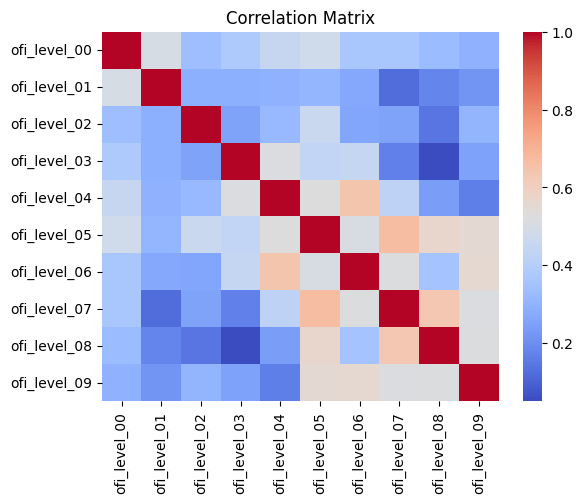


Correlation analysis:
Average correlation between levels: 0.434
Highest correlation: 1.000
Lowest correlation: 0.050

Correlations with best level (Level 0):
Level  1: 0.500
Level  2: 0.333
Level  3: 0.380
Level  4: 0.450
Level  5: 0.481
Level  6: 0.363
Level  7: 0.363
Level  8: 0.329
Level  9: 0.293


In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load our multi-level OFI data
individual_ofi = pd.read_csv('individual_level_ofi.csv')
individual_ofi['timestamp'] = pd.to_datetime(individual_ofi['timestamp'])

print("Step 4: Integrated OFI using PCA")
print("================================")

# Step 4.1: Analyze correlation structure of multi-level OFIs
ofi_level_cols = [f'ofi_level_{i:02d}' for i in range(10)]
ofi_level_data = individual_ofi[ofi_level_cols]

# Calculate correlation matrix
correlation_matrix = ofi_level_data.corr()

sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


# print("Correlation matrix between OFI levels:")
# print("Level", end="")
# for i in range(10):
#     print(f"   {i:2d}", end="")
# print()

# for i in range(10):
#     print(f"  {i:2d}", end="")
#     for j in range(10):
#         print(f" {correlation_matrix.iloc[i,j]:5.2f}", end="")
#     print()

# Summary statistics of correlations
print(f"\nCorrelation analysis:")
print(f"Average correlation between levels: {correlation_matrix.mean().mean():.3f}")
print(f"Highest correlation: {correlation_matrix.max().max():.3f}")
print(f"Lowest correlation: {correlation_matrix.min().min():.3f}")

# Show correlations with best level (level 0)
print(f"\nCorrelations with best level (Level 0):")
for i in range(1, 10):
    corr_with_best = correlation_matrix.iloc[0, i]
    print(f"Level {i:2d}: {corr_with_best:.3f}")

In [9]:
# Step 4.2: Apply PCA to multi-level OFI data

# Remove rows with all zeros (no activity)
non_zero_mask = (ofi_level_data != 0).any(axis=1)
ofi_active = ofi_level_data[non_zero_mask]

print(f"\nPCA Analysis:")
print(f"Total intervals: {len(ofi_level_data)}")
print(f"Intervals with activity: {len(ofi_active)} ({len(ofi_active)/len(ofi_level_data)*100:.1f}%)")

if len(ofi_active) > 0:
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    ofi_scaled = scaler.fit_transform(ofi_active)
    
    # Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(ofi_scaled)
    
    # Analyze explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"\nExplained variance by each principal component:")
    print("PC  | Variance | Cumulative")
    print("----|---------|-----------")
    for i in range(10):
        print(f" {i+1:2d} |  {explained_variance_ratio[i]:6.3f}  |   {cumulative_variance[i]:6.3f}")
    
    print(f"\nFirst PC explains {explained_variance_ratio[0]*100:.1f}% of variance")
    print(f"First 3 PCs explain {cumulative_variance[2]*100:.1f}% of variance")
    
    # Get the first principal component weights
    first_pc_weights = pca.components_[0]
    
    print(f"\nFirst Principal Component weights:")
    print("Level | Weight | Normalized")
    print("------|--------|----------")
    
    # Normalize weights so they sum to 1 (as mentioned in the paper)
    normalized_weights = np.abs(first_pc_weights) / np.sum(np.abs(first_pc_weights))
    
    for i in range(10):
        print(f"  {i:2d}  | {first_pc_weights[i]:6.3f} |   {normalized_weights[i]:6.3f}")

else:
    print("No active intervals found for PCA analysis")
    first_pc_weights = np.ones(10) / 10  # Equal weights fallback
    normalized_weights = first_pc_weights


PCA Analysis:
Total intervals: 71
Intervals with activity: 71 (100.0%)

Explained variance by each principal component:
PC  | Variance | Cumulative
----|---------|-----------
  1 |   0.444  |    0.444
  2 |   0.142  |    0.586
  3 |   0.097  |    0.683
  4 |   0.079  |    0.762
  5 |   0.069  |    0.831
  6 |   0.054  |    0.885
  7 |   0.043  |    0.928
  8 |   0.032  |    0.959
  9 |   0.024  |    0.983
 10 |   0.017  |    1.000

First PC explains 44.4% of variance
First 3 PCs explain 68.3% of variance

First Principal Component weights:
Level | Weight | Normalized
------|--------|----------
   0  |  0.317 |    0.102
   1  |  0.229 |    0.073
   2  |  0.247 |    0.079
   3  |  0.265 |    0.085
   4  |  0.332 |    0.106
   5  |  0.404 |    0.130
   6  |  0.361 |    0.116
   7  |  0.350 |    0.112
   8  |  0.295 |    0.095
   9  |  0.319 |    0.102


In [10]:
# Step 4.3: Calculate Integrated OFI using PCA weights

def calculate_integrated_ofi(ofi_data, weights, method='pca_weighted'):
    if method == 'pca_weighted':
        # Use PCA weights (paper's approach)
        integrated_ofi = np.zeros(len(ofi_data))
        for i in range(10):
            level_str = f"{i:02d}"
            col = f'ofi_level_{level_str}'
            integrated_ofi += weights[i] * ofi_data[col]
        
    elif method == 'equal_weighted':
        # Equal weights for comparison
        integrated_ofi = ofi_data[ofi_level_cols].mean(axis=1)
        
    elif method == 'inverse_level_weighted':
        # Weight by inverse level number
        level_weights = 1.0 / (np.arange(10) + 1)
        level_weights = level_weights / np.sum(level_weights)
        
        integrated_ofi = np.zeros(len(ofi_data))
        for i in range(10):
            level_str = f"{i:02d}"
            col = f'ofi_level_{level_str}'
            integrated_ofi += level_weights[i] * ofi_data[col]
    
    return integrated_ofi

# Calculate integrated OFI using different methods
integrated_results = {}

methods = ['pca_weighted', 'equal_weighted', 'inverse_level_weighted']
weights_dict = {
    'pca_weighted': normalized_weights,
    'equal_weighted': np.ones(10) / 10,
    'inverse_level_weighted': 1.0 / (np.arange(10) + 1)
}

for method in methods:
    weights = weights_dict[method]
    if method == 'inverse_level_weighted':
        weights = weights / np.sum(weights)  # Normalize
    
    integrated_ofi = calculate_integrated_ofi(individual_ofi, weights, method)
    integrated_results[method] = integrated_ofi
    
    print(f"\nIntegrated OFI using {method}:")
    print(f"  Mean: {integrated_ofi.mean():.2f}")
    print(f"  Std: {integrated_ofi.std():.2f}")
    print(f"  Range: [{integrated_ofi.min():.2f}, {integrated_ofi.max():.2f}]")
    print(f"  Non-zero: {(integrated_ofi != 0).sum()} / {len(integrated_ofi)} ({(integrated_ofi != 0).mean()*100:.1f}%)")

# Compare the different integrated OFI methods
print(f"\nComparison of Integrated OFI methods:")
print("Timestamp               | PCA Weight | Equal W.   | Inv Level W.")
print("------------------------|------------|------------|-------------")

for i in range(min(8, len(individual_ofi))):
    ts = individual_ofi.iloc[i]['timestamp'].strftime('%H:%M:%S')
    pca_val = integrated_results['pca_weighted'][i]
    equal_val = integrated_results['equal_weighted'][i]
    inv_val = integrated_results['inverse_level_weighted'][i]
    
    print(f"{ts}               | {pca_val:10.1f} | {equal_val:10.1f} | {inv_val:11.1f}")


Integrated OFI using pca_weighted:
  Mean: 15.91
  Std: 458.82
  Range: [-2203.60, 892.13]
  Non-zero: 71 / 71 (100.0%)

Integrated OFI using equal_weighted:
  Mean: 22.03
  Std: 473.62
  Range: [-2338.70, 953.30]
  Non-zero: 71 / 71 (100.0%)

Integrated OFI using inverse_level_weighted:
  Mean: -41.55
  Std: 585.79
  Range: [-3421.32, 776.06]
  Non-zero: 71 / 71 (100.0%)

Comparison of Integrated OFI methods:
Timestamp               | PCA Weight | Equal W.   | Inv Level W.
------------------------|------------|------------|-------------
11:54:00               |      138.4 |      143.8 |        80.4
11:55:00               |       50.3 |      108.9 |        -8.7
11:56:00               |      115.0 |      139.6 |       204.3
11:57:00               |      -87.7 |      -63.2 |        95.5
11:58:00               |      309.4 |      355.0 |       579.5
11:59:00               |       66.4 |       73.2 |       211.4
12:00:00               |      -35.6 |      -35.6 |        84.3
12:01:00      

In [11]:
# Step 4.4: Compare Integrated OFI with previous methods

# Load previous results
try:
    best_level_ofi = pd.read_csv('best_level_ofi.csv')
    best_level_ofi['timestamp'] = pd.to_datetime(best_level_ofi['timestamp'])
    
    multilevel_ofi = pd.read_csv('multilevel_ofi.csv')
    multilevel_ofi['timestamp'] = pd.to_datetime(multilevel_ofi['timestamp'])
    
    # Create comparison dataframe
    comparison_df = individual_ofi[['timestamp']].copy()
    comparison_df['integrated_ofi'] = integrated_results['pca_weighted']
    
    # Merge with previous results
    comparison_df = comparison_df.merge(best_level_ofi, on='timestamp', how='left')
    comparison_df = comparison_df.merge(multilevel_ofi, on='timestamp', how='left')
    
    # Fill NaN values with 0
    comparison_df = comparison_df.fillna(0)
    
    print(f"\nCorrelation analysis between OFI methods:")
    methods_to_compare = ['best_level_ofi', 'multilevel_ofi', 'integrated_ofi']
    
    print("Method 1          | Method 2          | Correlation")
    print("------------------|-------------------|------------")
    
    for i in range(len(methods_to_compare)):
        for j in range(i+1, len(methods_to_compare)):
            method1 = methods_to_compare[i]
            method2 = methods_to_compare[j]
            corr = comparison_df[method1].corr(comparison_df[method2])
            print(f"{method1:<17} | {method2:<17} | {corr:10.3f}")
    
    print(f"\nSample comparison of all OFI methods:")
    print("Timestamp               | Best Level | Multi Level | Integrated")
    print("------------------------|------------|-------------|------------")
    
    for i in range(min(8, len(comparison_df))):
        ts = comparison_df.iloc[i]['timestamp'].strftime('%H:%M:%S')
        best = comparison_df.iloc[i]['best_level_ofi']
        multi = comparison_df.iloc[i]['multilevel_ofi']
        integrated = comparison_df.iloc[i]['integrated_ofi']
        
        print(f"{ts}               | {best:10.1f} | {multi:11.1f} | {integrated:10.1f}")
        
    # Statistical comparison
    print(f"\nStatistical comparison:")
    for method in ['best_level_ofi', 'multilevel_ofi', 'integrated_ofi']:
        data = comparison_df[method]
        print(f"{method:<17}: Mean={data.mean():7.2f}, Std={data.std():7.2f}, Range=[{data.min():7.1f}, {data.max():7.1f}]")

except FileNotFoundError:
    print("Previous OFI files not found. Skipping comparison.")
    comparison_df = individual_ofi[['timestamp']].copy()
    comparison_df['integrated_ofi'] = integrated_results['pca_weighted']


Correlation analysis between OFI methods:
Method 1          | Method 2          | Correlation
------------------|-------------------|------------
best_level_ofi    | multilevel_ofi    |      0.711
best_level_ofi    | integrated_ofi    |      0.706
multilevel_ofi    | integrated_ofi    |      0.996

Sample comparison of all OFI methods:
Timestamp               | Best Level | Multi Level | Integrated
------------------------|------------|-------------|------------
11:54:00               |     -195.0 |      1438.0 |      138.4
11:55:00               |     -916.0 |      1089.0 |       50.3
11:56:00               |      199.0 |      1396.0 |      115.0
11:57:00               |      201.0 |      -632.0 |      -87.7
11:58:00               |      863.0 |      3550.0 |      309.4
11:59:00               |      208.0 |       732.0 |       66.4
12:00:00               |      498.0 |      -356.0 |      -35.6
12:01:00               |     -199.0 |      2843.0 |      237.4

Statistical comparison:
bes

In [12]:
# Step 4.5: Quality analysis of Integrated OFI

def analyze_ofi_quality(ofi_values, name="OFI"):
    non_zero = ofi_values[ofi_values != 0]
    
    print(f"\n{name} Quality Analysis:")
    print(f"Total observations: {len(ofi_values)}")
    print(f"Non-zero observations: {len(non_zero)} ({len(non_zero)/len(ofi_values)*100:.1f}%)")
    
    if len(non_zero) > 0:
        print(f"Non-zero statistics:")
        print(f"  Mean: {non_zero.mean():.2f}")
        print(f"  Std: {non_zero.std():.2f}")
        print(f"  Range: [{non_zero.min():.1f}, {non_zero.max():.1f}]")
        
        # Signal characteristics
        positive_pct = (non_zero > 0).mean() * 100
        print(f"  Positive signals: {positive_pct:.1f}%")
        print(f"  Negative signals: {100-positive_pct:.1f}%")
        
        # Magnitude distribution
        abs_values = np.abs(non_zero)
        print(f"  Small signals (< 10): {(abs_values < 10).mean()*100:.1f}%")
        print(f"  Medium signals (10-100): {((abs_values >= 10) & (abs_values < 100)).mean()*100:.1f}%")
        print(f"  Large signals (>= 100): {(abs_values >= 100).mean()*100:.1f}%")

# Analyze all our OFI methods
if 'comparison_df' in locals():
    for method in ['best_level_ofi', 'multilevel_ofi', 'integrated_ofi']:
        if method in comparison_df.columns:
            analyze_ofi_quality(comparison_df[method], name=method.replace('_', ' ').title())

# Show the PCA weights interpretation
print(f"\nPCA Weights Interpretation:")
print(f"The first principal component captures the main pattern of order flow imbalance")
print(f"across all levels. The weights show how much each level contributes:")

weights_to_show = normalized_weights if 'normalized_weights' in locals() else np.ones(10)/10

print(f"\nLevel | Weight | Interpretation")
print(f"------|--------|--------------------------------------------")
for i in range(10):
    weight = weights_to_show[i]
    if weight > 0.15:
        interp = "High contribution - very important level"
    elif weight > 0.08:
        interp = "Medium contribution - moderately important"
    else:
        interp = "Low contribution - less important level"
    
    print(f"  {i:2d}  | {weight:6.3f} | {interp}")

best_level = np.argmax(weights_to_show)
print(f"\nMost important level: {best_level} (weight: {weights_to_show[best_level]:.3f})")


Best Level Ofi Quality Analysis:
Total observations: 71
Non-zero observations: 67 (94.4%)
Non-zero statistics:
  Mean: -179.61
  Std: 783.47
  Range: [-4344.0, 1380.0]
  Positive signals: 44.8%
  Negative signals: 55.2%
  Small signals (< 10): 3.0%
  Medium signals (10-100): 14.9%
  Large signals (>= 100): 82.1%

Multilevel Ofi Quality Analysis:
Total observations: 71
Non-zero observations: 71 (100.0%)
Non-zero statistics:
  Mean: 220.32
  Std: 4736.23
  Range: [-23387.0, 9533.0]
  Positive signals: 56.3%
  Negative signals: 43.7%
  Small signals (< 10): 0.0%
  Medium signals (10-100): 1.4%
  Large signals (>= 100): 98.6%

Integrated Ofi Quality Analysis:
Total observations: 71
Non-zero observations: 71 (100.0%)
Non-zero statistics:
  Mean: 15.91
  Std: 458.82
  Range: [-2203.6, 892.1]
  Positive signals: 57.7%
  Negative signals: 42.3%
  Small signals (< 10): 1.4%
  Medium signals (10-100): 12.7%
  Large signals (>= 100): 85.9%

PCA Weights Interpretation:
The first principal compone

In [ ]:
# Step 4.6: Save Integrated OFI results

# Create final integrated OFI dataframe
final_integrated = individual_ofi[['timestamp']].copy()
final_integrated['integrated_ofi'] = integrated_results['pca_weighted']

# Add metadata about the calculation
metadata = {
    'method': 'PCA_weighted',
    'explained_variance_ratio': float(explained_variance_ratio[0]) if 'explained_variance_ratio' in locals() else None,
    'pca_weights': weights_to_show.tolist() if 'weights_to_show' in locals() else None,
    'n_components_used': 1,
    'total_intervals': len(final_integrated),
    'active_intervals': int((final_integrated['integrated_ofi'] != 0).sum())
}

# Save the results
final_integrated.to_csv('integrated_ofi.csv', index=False)

# Save metadata as a separate file
import json
with open('integrated_ofi_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nResults saved:")
print(f"- integrated_ofi.csv: Integrated OFI time series")
print(f"- integrated_ofi_metadata.json: PCA weights and calculation details")

# Final summary
print(f"\nStep 4 Summary - Integrated OFI:")
print(f"===============================")
print(f"- Used PCA to find optimal combination of 10 OFI levels")
if 'explained_variance_ratio' in locals():
    print(f"- First PC explains {explained_variance_ratio[0]*100:.1f}% of variance in multi-level OFI")
print(f"- Created single integrated metric that captures main order flow pattern")
print(f"- Weights automatically determined by data structure")
print(f"- Time intervals: {len(final_integrated)}")
print(f"- Active intervals: {(final_integrated['integrated_ofi'] != 0).sum()}")

if 'correlation_matrix' in locals():
    avg_corr = correlation_matrix.mean().mean()
    print(f"- Average correlation between levels: {avg_corr:.3f}")
    print(f"- Strong correlation justifies PCA approach")



Results saved:
- integrated_ofi.csv: Integrated OFI time series
- integrated_ofi_metadata.json: PCA weights and calculation details

Step 4 Summary - Integrated OFI:
- Used PCA to find optimal combination of 10 OFI levels
- First PC explains 44.4% of variance in multi-level OFI
- Created single integrated metric that captures main order flow pattern
- Weights automatically determined by data structure
- Time intervals: 71
- Active intervals: 71
- Average correlation between levels: 0.434
- Strong correlation justifies PCA approach
